## Wikidpedia page views for the cancer treatmeant drug, Tarceva.
### by Daniel Cuneo for the Meetup group, Scientists New to Data Science

###This notebook takes a look at Wikipedia page views. Wikipedia might be thought of as a proxy
###for other other media channel interest. For instance, national interest on the cancer drug Tarceva. It's difficult if not
###impossible to get a longish history of content views from Twitter, Youtube, Facebook, etc...but Wikipedia offers a full 7 seven years of basic usage stats. In addition, the contributor's stats on edits is available. That also might yield some interesting results. 

### For now, let's restrict ourselves to page views.

In [14]:
%matplotlib inline
# this sets up the default fig size
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 5)

In [15]:
import urllib2
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import json
from time import sleep

class WikiViews(object):
    def __init__(self, url, start_date, end_date):
        self.url = url
        self.url_base = "http://stats.grok.se/json/en/%(date)s/%(url)s" 
        self.date_range = pd.date_range(start=start_date, end=end_date, freq='m')

    def loop_over_full_dates(self):
        DF = pd.DataFrame()
        
        for date in self.date_range:
            date_string = date.strftime("%Y%m")
            url = self.url_base %{'date':date_string,
                                  'url':self.url
                                  }
           
            try:
                response = urllib2.urlopen(url)
                out = response.read()
            except urllib2.HTTPError:
                print "HTTP Error, trying again."
                sleep(2)
                response = urllib2.urlopen(url)
                out = response.read()
            except Exception, err:
                print err
                raise Exception    
            finally:
                response.close()
                
            out = json.loads(out)
            df = pd.DataFrame(out, columns=['daily_views'])
            
            DF = DF.append(df)
            
        return DF
    
    def plot_time_series(self, days_df):
        #plt.figure(figsize=(13, 7))
        
        y = days_df.daily_views
        plt.plot(y)
        plt.xlim(0, y.shape[0])
        
        interval = 20 # days
        labels = days_df.index.tolist()
        labels = labels[0::interval]
        
        n = np.arange(days_df.shape[0])[0::interval]
        plt.xticks(n, labels, rotation='vertical')
    
        plt.show()
    
    def fft(self, data):
        plt.figure(figsize=(13, 7))
        f, y = scipy.signal.welch(data, fs=1.0, nperseg=256, noverlap=128, nfft=512, scaling='spectrum', detrend="constant")
        
        interval = 3 # days
        periods = np.round(1/f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0
        
        plt.xticks(f[0::interval], periods, rotation="vertical")
        
        plt.plot(f, y)
        plt.show()
        
        return f, y



In [3]:
wv = WikiViews("Erlotinib", '1/1/2008', '4/5/2015' )
days_df = wv.loop_over_full_dates()

Let's take a look a the time series data.

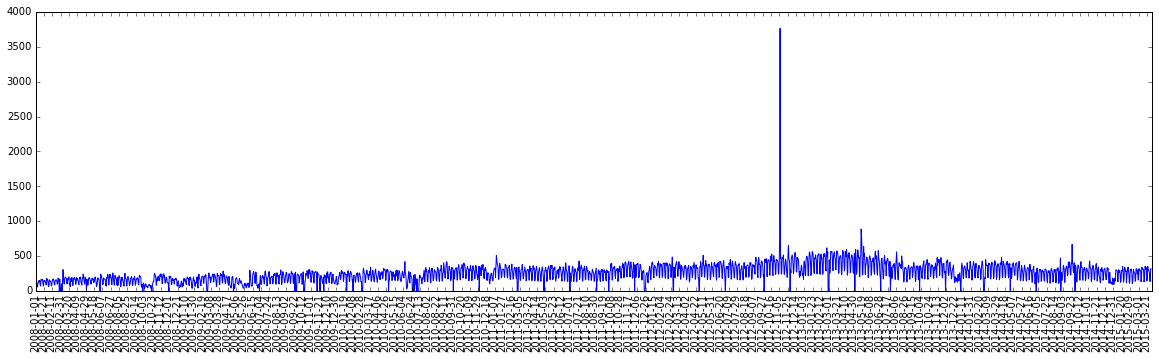

In [4]:
wv.plot_time_series(days_df)

Looks to me like there's a linear increase over time. I think that's due to increased public use of Wikipedia. 
Let's detrend.

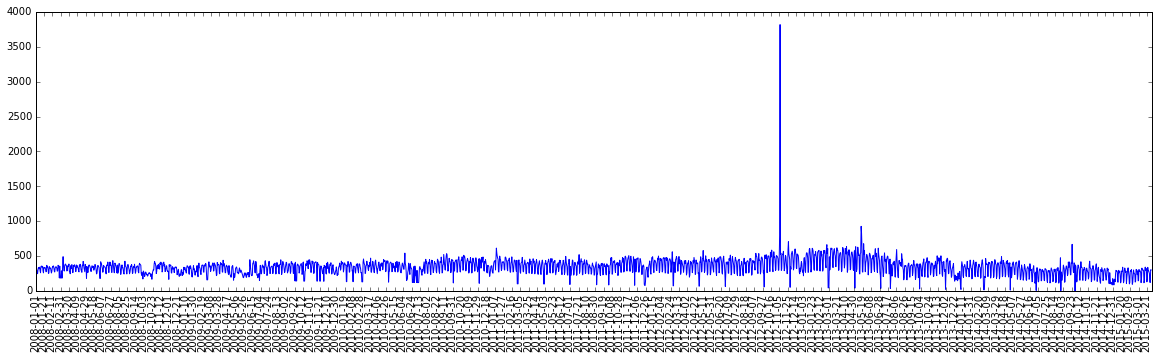

In [5]:
dates = days_df.index
views = days_df['daily_views'].squeeze()
views = scipy.signal.detrend(views, type='linear')
views -= views.min() # undo the centering
views = np.int16(np.round(views, decimals=0))
df = pd.DataFrame({"daily_views":views})
df.set_index(dates, inplace=True)
wv.plot_time_series(df)

Now we'd like to see some frequency anaylsis. The FFT won't tell us what day(s) the cycles repeat on,
but it will show if any periodicity exists. 

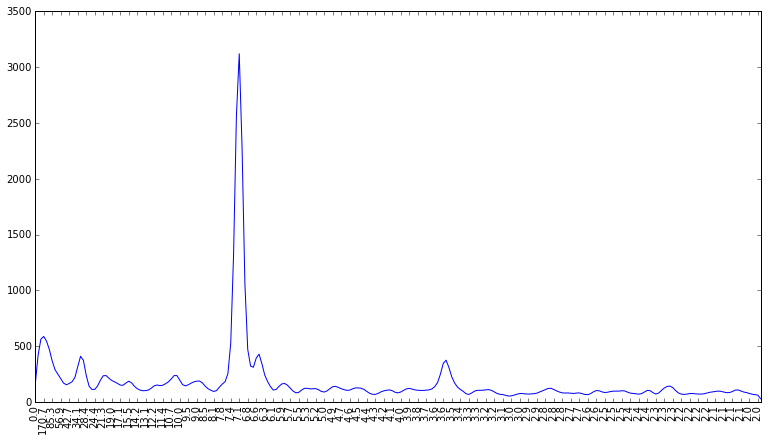

In [6]:
freq, amp = wv.fft(df.daily_views)

There's a clear weekly frequency that I've seen in other social media channels. People may look use Wikipedia on the weekends more so than weekdays. The longer periods are interesting at about a month and three months. The next step would be to look for covarites to explain the time series and the periodicity. 

In [7]:
df.to_csv(path_or_buf="/home/daniel/tarceva_wiki_views.csv")

I don't have covariates to do a GLM at this time. That is a pretty big task that an analyst should really do with help from the data scientist. I would try to use brand tweets or other owned media as well as blog and forums posts.

### Let's do some signal processing, in particular, Filtering
With straight numeric data from sensors ( typically voltages ), it's a lot more straight forward not to process the signals. There's samplerates, signal to noise ratios, published bandwidths....with social media NONE OF THAT EXISTS ! We either get our own parameters from more data or make heuristic guesses.

In [8]:
import scipy.signal as sig
data = df.daily_views

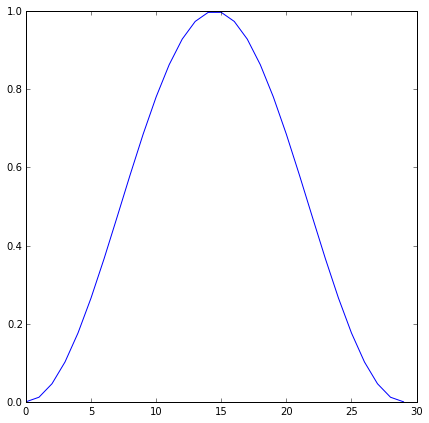

In [9]:
window = np.hanning(30)
plt.figure(figsize=(7,7))
plt.plot(window)

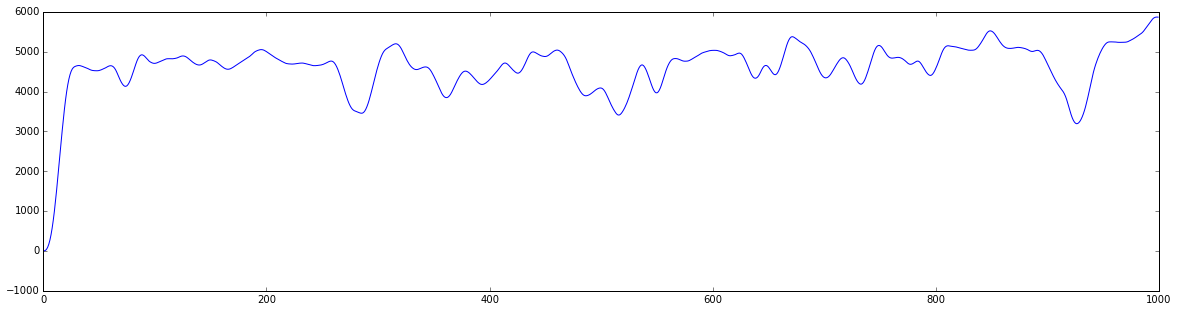

In [10]:
data_filt_30 = sig.fftconvolve(window, data)
plt.plot(data_filt_30[0:1000])

## Before the Filter

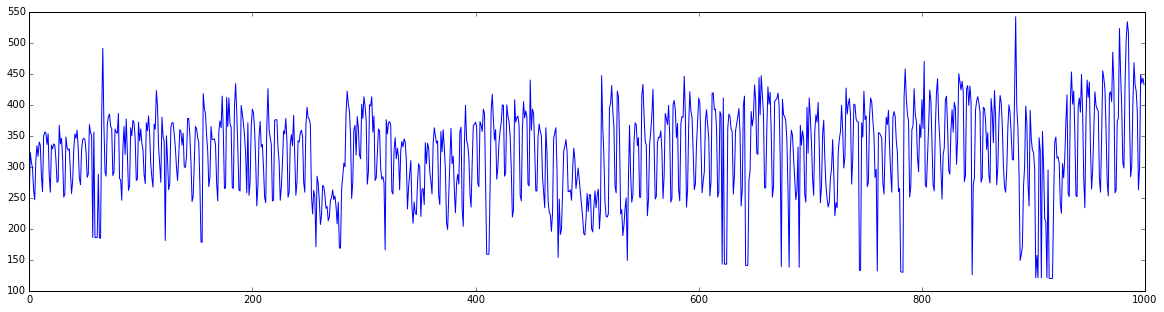

In [11]:
plt.figure()
plt.plot(data[0:1000])

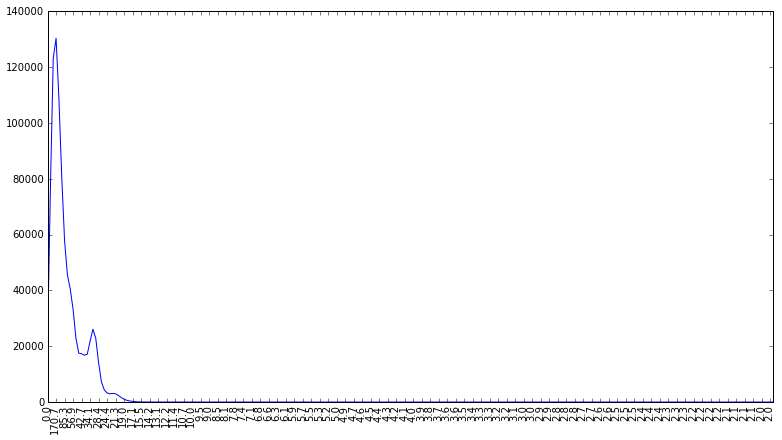

In [12]:
freq, y = wv.fft(data_filt_30)

###Although the peak looks bigger, there is no straight forward way to scale the y axis so we need to 
###not be too impressed with that. Really, the same two peaks are present as in the original FFT. This plot is simply cleaner. This might seem dumb, but if we where writing a peak-detector, then we'd want a simpler data set.
##Let's find peaks.

In [13]:
import sys
sys.path.append("/home/daniel/git/Python2.7/MRI/Modules")
import SignalProcessTools
sigtools = SignalProcessTools.SignalProcessTools()

ImportError: No module named nipy

### The Savitzky-Golay filer was taken from here: http://wiki.scipy.org/Cookbook/SavitzkyGolay

In [ ]:
def peak_detection(data):
    der1 = sigtools.savitzky_golay(data, window_size=3, order=1, deriv=1)
    der2 = sigtools.savitzky_golay(data, window_size=5, order=2, deriv=2)
    zero_crossings_test = der1[0:-1] * der1[1:]
    peaks = np.where((der2[0:-1] < 0) & (zero_crossings_test < 0))[0]
    
    return peaks

In [ ]:
peaks = peak_detection(data_filt_30)

In [ ]:
plt.plot(data_filt_30)
plt.vlines(peaks, 0, data_filt_30.max())

In [ ]:
peaks = peak_detection(y)
plt.figure()
plt.plot(freq, y)
plt.vlines(freq[peaks], 0, y.max(), 'r')

### There's still some ripple out to the right. We'll still need to use logic.



In [ ]:
y_peaks = y[peaks]
freq_peaks = freq[peaks]

peak_ref = np.max(y_peaks)
keep_peaks = np.where(y_peaks >= 0.1 * peak_ref)[0]

In [ ]:
plt.plot(freq, y)
plt.vlines(freq_peaks[keep_peaks], 0, y_peaks.max(), 'r')